# Parallel processing of a stack of data stored in HDF5 with multi-threading

This tutorial explains how it is possible to treat in parallel a large HDF5 dataset which does not fit into the computer memory.

![Typical workflow](workflow.png)

For this tutorial, a recent version of pyFAI is needed (>=0.22, summer 2022).

This tutorial expains how to take benefit from multi-threading. This framework is not very popular in the Python world due to the [Global Interpreter Lock (GIL)](https://wiki.python.org/moin/GlobalInterpreterLock), but properly written C-code which does release the GIL can be very fast, sometimes as fast as GPU code (on large computers).

**Credits:**

* Thomas Vincent (ESRF) for the parallel decompression of HDF5 chunks and the Jupyter-slurm
* Pierre Paleo (ESRF) for struggling with this kind of stuff with GPUs
* Jon Wright (ESRF) for the CSC integrator, while implemented in serial is multithreading friendly + HDF5 investigation
* The French-CRG for providing a manycore computer (2 x 32-core AMD EPYC 75F3)

**Nota:** No GPU is needed for this tutorial!

**Important:** the `bitshuffle` module needs to be compiled without OpenMP, since the tutorial aims at demonstrating that Python threads can be almost as efficient as OpenMP. If you have a doubt about OpenMP, please uncomment the environment variable OMP_NUM_THREADS reset in the second cell. This will unfortunately bias the performance measurement of pyFAI with the CSR sparse-matrix multiplication.

## 1. Description of the computer.

The results obtained vary a lot as function of the computer and its topology. This section details some internal details about the computer.

In [1]:
%matplotlib inline
# use `widget` for better user experience; `inline` is for documentation generation

In [2]:
import sys, os, collections, struct, time, socket
# Ensure OpenMP is disabled
os.environ["OMP_NUM_THREADS"] = "1"
import numpy, pyFAI
import h5py, hdf5plugin
from queue import Queue
import threading
import bitshuffle
from matplotlib.pyplot import subplots
start_time = time.time()
Item = collections.namedtuple("Item", "index data")
print(f"Working on computer {socket.gethostname()}.")

Working on computer hpc6-04.


In [3]:
nbthreads = len(os.sched_getaffinity(0))
print(f"Working with {nbthreads} threads. Mind OpenMP needs to be disabled in the bitshuffle code !")

Working with 64 threads. Mind OpenMP needs to be disabled in the bitshuffle code !


In [4]:
!lscpu

Architecture:                    x86_64
CPU op-mode(s):                  32-bit, 64-bit
Byte Order:                      Little Endian
Address sizes:                   48 bits physical, 48 bits virtual
CPU(s):                          64
On-line CPU(s) list:             0-63
Thread(s) per core:              1
Core(s) per socket:              32
Socket(s):                       2
NUMA node(s):                    2
Vendor ID:                       AuthenticAMD
CPU family:                      25
Model:                           1
Model name:                      AMD EPYC 75F3 32-Core Processor
Stepping:                        1
Frequency boost:                 enabled
CPU MHz:                         1493.870
CPU max MHz:                     2950.0000
CPU min MHz:                     1500.0000
BogoMIPS:                        5888.66
Virtualization:                  AMD-V
L1d cache:                       2 MiB
L1i cache:                       2 MiB
L2 cache:                        32 MiB

In [5]:
!numactl --hardware

available: 2 nodes (0-1)
node 0 cpus: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31
node 0 size: 257524 MB
node 0 free: 244301 MB
node 1 cpus: 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63
node 1 size: 257995 MB
node 1 free: 211831 MB
node distances:
node   0   1 
  0:  10  32 
  1:  32  10 


In [6]:
!lstopo --of console

Machine (503GB total)
  Package L#0
    NUMANode L#0 (P#0 251GB)
    L3 L#0 (32MB)
      L2 L#0 (512KB) + L1d L#0 (32KB) + L1i L#0 (32KB) + Core L#0 + PU L#0 (P#0)
      L2 L#1 (512KB) + L1d L#1 (32KB) + L1i L#1 (32KB) + Core L#1 + PU L#1 (P#1)
      L2 L#2 (512KB) + L1d L#2 (32KB) + L1i L#2 (32KB) + Core L#2 + PU L#2 (P#2)
      L2 L#3 (512KB) + L1d L#3 (32KB) + L1i L#3 (32KB) + Core L#3 + PU L#3 (P#3)
    L3 L#1 (32MB)
      L2 L#4 (512KB) + L1d L#4 (32KB) + L1i L#4 (32KB) + Core L#4 + PU L#4 (P#4)
      L2 L#5 (512KB) + L1d L#5 (32KB) + L1i L#5 (32KB) + Core L#5 + PU L#5 (P#5)
      L2 L#6 (512KB) + L1d L#6 (32KB) + L1i L#6 (32KB) + Core L#6 + PU L#6 (P#6)
      L2 L#7 (512KB) + L1d L#7 (32KB) + L1i L#7 (32KB) + Core L#7 + PU L#7 (P#7)
    L3 L#2 (32MB)
      L2 L#8 (512KB) + L1d L#8 (32KB) + L1i L#8 (32KB) + Core L#8 + PU L#8 (P#8)
      L2 L#9 (512KB) + L1d L#9 (32KB) + L1i L#9 (32KB) + Core L#9 + PU L#9 (P#9)
      L2 L#10 (512KB) + L1d L#10 (32KB) + L1i L#10 (32KB) + Core L#10 +

## 2. Setup the enviroment:

This is a purely virtual experiment, the tutorial tries to be representative of the processing for the beamline of Jon Wright: ESRF-ID11 this is why we will use an Eiger 4M detector with data integrated over 1000 bins. Those parameters can be tuned.

Random data are generated to mimic the scattering of a liquid with Poisson noise. The input file is fairly small, since those data compress nicely. The speed of the drive used for temporary storage is likely to have a huge impact, especially if all data do not hold in memory !

In [7]:
det = pyFAI.detector_factory("eiger_4M")
shape = det.shape
dtype = numpy.dtype("uint32")
filename = "/tmp/big.h5"
h5path = "data"
nbins = 1000
cmp = hdf5plugin.Bitshuffle()
hdf5plugin.get_config().build_config

HDF5PluginBuildConfig(openmp=True, native=True, bmi2=True, sse2=True, avx2=True, avx512=False, cpp11=True, cpp14=True, ipp=False, filter_file_extension='.so', embedded_filters=('blosc', 'blosc2', 'bshuf', 'bzip2', 'fcidecomp', 'lz4', 'sz', 'sz3', 'zfp', 'zstd'))

In [8]:
mem_bytes = os.sysconf('SC_PAGE_SIZE') * os.sysconf('SC_PHYS_PAGES')
print(f"Number of frames the computer can host in memory: {mem_bytes/(numpy.prod(shape)*dtype.itemsize):.3f}")
if os.environ.get('SLURM_MEM_PER_NODE'):
    print(f"Number of frames the computer can host in memory with SLURM restrictions: {int(os.environ['SLURM_MEM_PER_NODE'])*(1<<20)/(numpy.prod(shape)*dtype.itemsize):.3f}")

Number of frames the computer can host in memory: 30127.005
Number of frames the computer can host in memory with SLURM restrictions: 3829.928


In [9]:
#The computer being limited to 64G of RAM, the number of frames actually possible is 3800.
nbframes = 4096 # slightly larger than the maximum achievable ! Such a dataset should not host in memory.

In [10]:
#Prepare a frame with little count so that it compresses well
geo = {"detector": det, 
       "wavelength": 1e-10}
ai = pyFAI.load(geo)
q = numpy.arange(15)
img = ai.calcfrom1d(q, 100/(1+q*q))
frame = numpy.random.poisson(img).astype(dtype)

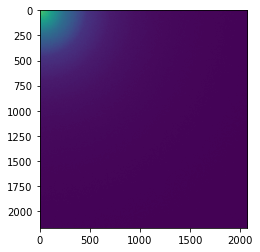

In [11]:
# display the image
fig,ax = subplots()
ax.imshow(frame)

In [12]:
print("Performances of the different algorithms for azimuthal integration of Eiger 4M image")
for algo in ("histogram", "csc", "csr"):
    print(f"Using algorithm {algo:10s}:", end=" ")
    %timeit ai.integrate1d(img, nbins, method=("full", algo, "cython"))

Performances of the different algorithms for azimuthal integration of Eiger 4M image
Using algorithm histogram : 420 ms ± 6.95 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Using algorithm csc       : 38.1 ms ± 1.21 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Using algorithm csr       : 46.8 ms ± 676 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


**Note:** The full pixel splitting is time consuming and handicaps the histogram algorithm while both sparse-matrix methods are much faster since they cache this calculation in the sparse matrix.

The compared performances of sparse-matrix methods is rather surprizing since the CSC algorithm, single threaded, is faster than the CSR which runs in parallel over 2x32 cores.
This result is the combination of two facotors:

1. The computer is built with two processors/sockets controling each its own memory. We call this a **Non Uniform Memory Access** computer and can be checked with `numactrl --hardware`. The CSR matrix multiplication will dispatch work on both processors and thus, needs to transfer part of the image from one NUMA subsystem (socket) to the other, which is slow (3.2x slower compared to a single-socket access, according to the output of numactl). 

2. The very large cache of this processor: 512MB are reported by `lscpu`, but a more precise tool, `lstopo` describes them as 32MB of L3 cache shared between 4 cores. This very large cache allows the complete frame and the sparse matrix to be pre-fetched which is a great advantage for the CSC algorithm.

Running the very same benchmark on an Intel 2-socket server would remove the point 2, while running on a singe socket intel workstation would remove both points and the normal results would be that CSR should be faster than CSC. The best performances on can get with the CSR algorithm should be obtained when using 4 cores (sharing the same cache L3) out of 64 on this computer. This can be done by setting the environment variable **OMP_NUM_THREADS**. Unfortunately, it also requires to restart the process, thus cannot be demonstrated easily in the notebook (without restarting). 

**The first message to take home is that without the knownledge of the actual computer, no high-performace computing is possible**

In [13]:
#Does not work unless one restarts the process

# print("Performances of the different algorithms for azimuthal integration of Eiger 4M image when using only 4 cores")
# mask = os.sched_getaffinity(0)
# os.sched_setaffinity(0, [0,1,2,3])
# for algo in ("histogram", "csc", "csr"):
#     print(f"Using algorithm {algo}:", end=" ")
#     %timeit ai.integrate1d(img, nbins, method=("full", algo, "cython"))
# os.sched_setaffinity(0, mask)

## 3. Writing the test dataset on disk.

In [14]:
%%timeit -r1 -n1 -o -q
#Saving of a HDF5 file with many frames ...
if not os.path.exists(filename):
    with h5py.File(filename, "w") as h:
        ds = h.create_dataset(h5path, shape=(nbframes,)+shape, chunks=(1,)+shape, dtype=dtype, **cmp) 
        for i in range(nbframes):
            ds[i] = frame + i%500 #Each frame has a different value to prevent caching effects

<TimeitResult : 42 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)>

In [15]:
timing_write = _
size=os.stat(filename).st_size
print(f"File size {size/(1024**3):.3f} GB with a compression ratio of {nbframes*numpy.prod(shape)*dtype.itemsize/size:.3f}x")
print(f"Write speed: {nbframes*numpy.prod(shape)*dtype.itemsize/(1e6*timing_write.best):.3f} MB/s of uncompressed data, or {nbframes/timing_write.best:.3f} fps.")

File size 9.214 GB with a compression ratio of 7.429x
Write speed: 1748.975 MB/s of uncompressed data, or 97.475 fps.


No optimisation is done for writing: this tutorial is focused on reading & processing speed.
We keep nevertheless those figures for reference.

## 4. Reading the dataset using the h5py/HDF5 library:
### 4.1 Using the `h5py` API in a natural way
We start with the simplest way to read back all those data:

In [16]:
%%timeit -r1 -n1 -o -q
#Reading all frames and decompressing them, the natural way way
with h5py.File(filename, "r") as h:
    ds = h[h5path]
    for i in range(nbframes):
        frame = ds[i][...]

<TimeitResult : 25 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)>

In [17]:
timing_read0 = _
print(f"Read speed: {nbframes*numpy.prod(shape)*dtype.itemsize/(1e6*timing_read0.best):.3f} MB/s of uncompressed data,\
 or {nbframes/timing_read0.best:.3f} fps.")

Read speed: 2935.324 MB/s of uncompressed data, or 163.594 fps.


Reading all data from HDF5 file is as slow as (if not slower than) writing. 
This is mostly due to the decompression and to the many memory allocation performed.

### 4.2 Pre-allocate the output buffer (for `h5py`)

Now, we can try to pre-allocate the output buffer and check if it helps:

In [18]:
%%timeit -r1 -n1 -o -q
#Reading all frames and decompressing them
buffer = numpy.zeros(shape, dtype=dtype)
with h5py.File(filename, "r") as h:
    ds = h[h5path]
    for i in range(nbframes):
        ds.read_direct(buffer, numpy.s_[i,:,:], numpy.s_[:,:])

<TimeitResult : 22.6 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)>

In [19]:
timing_read1 = _
print(f"Read speed: {nbframes*numpy.prod(shape)*dtype.itemsize/(1e6*timing_read1.best):.3f} MB/s of uncompressed data,\
 or {nbframes/timing_read1.best:.3f} fps.")

Read speed: 3247.430 MB/s of uncompressed data, or 180.988 fps.


In [20]:
print(f" Speed-up: {(timing_read0.best/timing_read1.best-1)*100:.1f} %")

 Speed-up: 10.6 %


The gain exists but it is not huge (10%).

## 5. Decouple HDF5 chunk reading from decompression.

We will benchmark separately the file reading (i.e. reading chunks one by one) and decompressing to check the maximum achievable read speed.

### 5.1 Benchmarking of the chunk reading using the `read_direct_chunk` from `h5py`

In [21]:
%%timeit -r1 -n1 -o -q
#Reading all frames without decompressing them
with h5py.File(filename, "r") as h:
    ds = h[h5path]
    for i in range(ds.id.get_num_chunks()):
        filter_mask, chunk = ds.id.read_direct_chunk(ds.id.get_chunk_info(i).chunk_offset)

<TimeitResult : 908 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)>

In [22]:
timing_read2 = _
print(f"Read speed: {size/(1e6*timing_read2.best):.3f} MB/s of compressed data.")
print(f"HDF5 direct chunk read speed: {nbframes/timing_read2.best:.3f} fps (without decompression).")

Read speed: 10900.036 MB/s of compressed data.
HDF5 direct chunk read speed: 4512.810 fps (without decompression).


The reading part data is really fast, it is apparently mostly by the disk speed or by the memory (if the compressed dataset stays in memory). 

### 5.2 Benchmarking of the decompression (single threaded)

The function `decompress_bslz4_chunk` can be used to decompress one chunk.
We benchmark it on one chunk

In [23]:
def decompress_bslz4_chunk(payload, dtype, chunk_shape):
    """This function decompresses ONE chunk with bitshuffle-LZ4. 
    The library needs to be compiled without OpenMP when using threads !
    
    :param payload: string with the compressed data as read by h5py.
    :param dtype: data type of the stored content
    :param chunk_shape: shape of one chunk
    :return: decompressed chunk"""
    total_nbytes, block_nbytes = struct.unpack(">QI", payload[:12])
    block_size = block_nbytes // dtype.itemsize

    arr = numpy.frombuffer(payload, dtype=numpy.uint8, offset=12)  # No copy here
    chunk_data = bitshuffle.decompress_lz4(arr, chunk_shape, dtype, block_size)
    return chunk_data

In [24]:
frame_id = 123
with h5py.File(filename, "r") as h:
    ds = h[h5path]
    filter_mask, chunk = ds.id.read_direct_chunk(ds.id.get_chunk_info(frame_id).chunk_offset)
    
print(f"Read chunk #{frame_id} which is {len(chunk)} bytes long.")
frame = decompress_bslz4_chunk(chunk, dtype, shape)
print(f"The decompressed frame is {frame.nbytes} bytes long")
print(f"This frame is compressed with a ratio of {frame.nbytes/len(chunk):.1f} x.")
print("Benchmarking the decompression: ", end="")
timing_decompression = %timeit -o decompress_bslz4_chunk(chunk, dtype, shape)
print(f"Decompression speed (single threaded): {1/timing_decompression.best:.3f} fps")
print(f"Maximum read+decompression speed (single threaded): {1/(timing_decompression.best+timing_read2.best/nbframes):.3f} fps")
print(f"Maximum read+decompression speed ({nbthreads}-threads): {1/(timing_decompression.best/nbthreads+timing_read2.best/nbframes):.3f} fps")

Read chunk #123 which is 2605242 bytes long.
The decompressed frame is 17942760 bytes long
This frame is compressed with a ratio of 6.9 x.
Benchmarking the decompression: 3.98 ms ± 5.97 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Decompression speed (single threaded): 251.329 fps
Maximum read+decompression speed (single threaded): 238.070 fps
Maximum read+decompression speed (64-threads): 3524.092 fps


At this stage it is interesting to compare the maximum achievable speed in parallel and the raw read speed.

This difference is known as [Amdahl's law](https://en.wikipedia.org/wiki/Amdahl%27s_law) which states that performances of a parallel program become limited limited by the serial part of it when the number of threads increases. In other words, find all the serial sections and squeeze them to get performances.

Some part of the code are made serial to prevent data corruption. One typical example are the commands seek+read in file. If several threads are doing this at the same time, the file-pointer is likely to be changed and the read will return the wrong data. Serializing this section, for example by using locks, mutex, semaphores, ...  is a simple way to prevent such issues. Let's list some of the lock we have in this example:

- `h5py` has a lock called `phil` which serializes the access to the HDF5 library
- `HDF5` has a global lock preventing files from being modified from different processes
- `Python` has a global interpreter lock `GIL` which ensures only one python object is manipulated at a time.

The later is widely commented and an urban legend says it prevents multithreading in Python. 
You will at the end of the tutorial how much this is True (or not). 


### 5.3 Benchmark the analysis of the HDF5 file

To come back on the parallel reading, the different locks from `h5py` and `HDF5` are preventing us from a parallel access to the data.
Can we dive deeper into the `HDF5` file and retrieve the position of the different chunks and their size ? 
If so, it would be possible read chunks without the `h5py`/`HDF5` library, working around their different locks.

Let's check the parsing of the HDF5 structure of the dataset

In [25]:
with h5py.File(filename, "r") as h:
    ds = h[h5path]
    res = [ds.id.get_chunk_info(i) for i in range(ds.id.get_num_chunks())]
print(f"Each chunk descriptor is an object like: \n{res[0]}")
print(f"It represents a very small amount of data: {sys.getsizeof(res[0])} bytes.")
print(f"All {nbframes} frames, weighting {size/1e6:.3f} MB, can be represented by {(sys.getsizeof(res)+sys.getsizeof(res[0])*nbframes)/1000:.3f} kB")

Each chunk descriptor is an object like: 
StoreInfo(chunk_offset=(0, 0, 0), filter_mask=0, byte_offset=4536, size=1972400)
It represents a very small amount of data: 72 bytes.
All 4096 frames, weighting 9893.291 MB, can be represented by 327.960 kB


In [26]:
%%timeit -r1 -n1 -o -q
#Parsing speed
with h5py.File(filename, "r") as h:
    ds = h[h5path]
    res = [ds.id.get_chunk_info(i) for i in range(ds.id.get_num_chunks())]

<TimeitResult : 239 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)>

In [27]:
timing_parse = _
print(f"Parse speed: {size/(1e6*timing_parse.best):.3f} MB/s of compressed data.")
print(f"HDF5 parse speed (without reading): {nbframes/timing_parse.best:.3f} fps.")

Parse speed: 41444.687 MB/s of compressed data.
HDF5 parse speed (without reading): 17158.845 fps.


In [28]:
# Validation that the data read by HDF5 and via the file interface matches
import hashlib
idx = 10
with h5py.File(filename, "r") as h:
    ds = h[h5path]
    indexes = [ds.id.get_chunk_info(i) for i in range(ds.id.get_num_chunks())]
    filter_mask, ref = ds.id.read_direct_chunk(indexes[idx].chunk_offset)
# and validate the indexes
with open(filename, "rb") as f:
    item = indexes[idx]
    f.seek(item.byte_offset)
    res = f.read(item.size)
print(f"{hashlib.sha1(ref).hexdigest()} using HDF5\n{hashlib.sha1(res).hexdigest()} using direct file access")

db3ee77199ed8aef5aac34b91f86b3deac7bea66 using HDF5
db3ee77199ed8aef5aac34b91f86b3deac7bea66 using direct file access


So the HDF5 chunk parsing is the only part of the code needing to be serial, so the maximum achievable speed is very high: 12 kfps.

If Amdahl's law is providing us with the upper performance limit, one should take care to optimize all the code to be run in parallel. 

Here are two ways to read the different chunks, either using the `Python file` interface or `numpy.memmap`. 
Their performances are expected to be similar to what `HDF5 direct chunk read` provides, the idea is to use them to bypass the locks in `HDF5`.

### 5.4 Benchmark the chunk reading using the `h5py` direct chunk read

In [29]:
%%timeit -r1 -n1 -o -q
#Reading all frames without decompressing them
with h5py.File(filename, "r") as h:
    ds = h[h5path]
    for chunk_descr in indexes:
        filter_mask, chunk = ds.id.read_direct_chunk(chunk_descr.chunk_offset)

<TimeitResult : 619 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)>

In [30]:
timing_read2a = _
print(f"Read speed (h5py direct chunk read): {size/(1e6*timing_read2a.best):.3f} MB/s of compressed data.")
print(f"Chunk read (from h5py) speed (without decompression): {nbframes/timing_read2a.best:.3f} fps.")

Read speed (h5py direct chunk read): 15994.548 MB/s of compressed data.
Chunk read (from h5py) speed (without decompression): 6622.030 fps.


### 5.5 Benchmark the chunk reading using the Python file interface

In [31]:
%%timeit -r1 -n1 -o -q
#Reading all frames without using the HDF5 library (neither decompressing them)
with open(filename, "rb") as f:
    for chunk_descr in indexes:
        f.seek(chunk_descr.byte_offset)
        chunk = f.read(chunk_descr.size)

<TimeitResult : 613 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)>

In [32]:
timing_read3 = _
print(f"Read speed (Python file): {size/(1e6*timing_read3.best):.3f} MB/s of compressed data.")
print(f"File read (from Python) speed (without decompression): {nbframes/timing_read3.best:.3f} fps.")
print(f"Pure reading using the Python (file interface) is {100*timing_read2a.best/(timing_read3.best)-100:.1f} % faster than HDF5 direct chunk read.")
print("But it removes the file-locking issue from HDF5 !")

Read speed (Python file): 16127.053 MB/s of compressed data.
File read (from Python) speed (without decompression): 6676.890 fps.
Pure reading using the Python (file interface) is 0.8 % faster than HDF5 direct chunk read.
But it removes the file-locking issue from HDF5 !


### 5.5 Benchmark the chunk reading using `numpy.memmap`

In [33]:
%%timeit -r1 -n1 -o -q
#Reading positions via HDF5 but chunks are read via numpy.memmap
f = numpy.memmap(filename, mode="r")
for chunk_descr in indexes:
    chunk = numpy.array(f[chunk_descr.byte_offset:chunk_descr.byte_offset+chunk_descr.size])
del f

<TimeitResult : 758 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)>

In [34]:
timing_read4 = _
print(f"Read speed (numpy.memmap): {size/(1e6*timing_read4.best):.3f} MB/s of compressed data.")
print(f"File read (numpy.memmap) speed (without decompression): {nbframes/timing_read4.best:.3f} fps.")
print(f"Pure reading using the numpy.memmap is {100*timing_read2a.best/(timing_read4.best)-100:.1f} % faster than using the h5py/HDF5 interface")
print("This removes the file-locking issue from HDF5 !")

Read speed (numpy.memmap): 13048.649 MB/s of compressed data.
File read (numpy.memmap) speed (without decompression): 5402.375 fps.
Pure reading using the numpy.memmap is -18.4 % faster than using the h5py/HDF5 interface
This removes the file-locking issue from HDF5 !


Numpy's memmap apprears to be much slow than the equivalent python file read.

We found out that the reading of data, initially in the order of 1 minute can be decomposed into:

 * 0.3s for the reading of the chunk description
 * 1s for the reading of the chunks themselves
 * 1 minute for the decompression of the data.

Two parallelization schemes appear clearly:
1. read chunks in serial mode with h5py and decompress+integrate in parallel.
2. read chunk descriptors in serial mode with h5py and parallelize the reading, decompression and integration.

But befor we can investigate those two routes, we first need to establish some baseline for the complete serial processing: read, decompress, integrate.

## 6. Azimuthal integration

### 6.1 Serial workflow


#### 6.1.1 Prepare the azimuthal integrator
To allow the full parallelization of different integrators working in parallel, one must limit the number of Python call performed, this is why we need to extract the Cython integrator from AzimuthalIntegator. The integrator used here is a sparse matrix multiplication one with a CSC representation which is single-threaded. This engine is usually not the fastest but it is multitheading friendly.

The figures obtained should be similar to the one obtaind in chapter 2, the overhead from the azimuthal integrator being tuned to be minimal.

In [35]:
geo = {"detector": det, 
       "wavelength": 1e-10}
ai = pyFAI.load(geo)
omega = ai.solidAngleArray()
res0 = ai.integrate1d(frame, nbins, method=("full", "csc", "cython"))
engine = ai.engines[res0.method].engine
#This is how the engine works:
res1 = engine.integrate_ng(frame, solidangle=omega)
assert numpy.allclose(res0.intensity, res1.intensity)  # validates the equivalence of both approaches:
print("Timing for the direct azimuthal integration: ", end="")
timing_integration = %timeit -o engine.integrate_ng(frame, solidangle=omega)
print(f"The maximum achievable integration speed on a single core is {1/timing_integration.best:.3f} fps which does not look fancy.")
print(f"But parallelized over {nbthreads} threads, it could reach: {nbthreads/timing_integration.best:.3f} fps!")

Timing for the direct azimuthal integration: 37.1 ms ± 44.1 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
The maximum achievable integration speed on a single core is 27.041 fps which does not look fancy.
But parallelized over 64 threads, it could reach: 1730.592 fps!


### 6.1.2 Benchmarking of the serial workflow

This code tries to be simple and elegant. 
It provides the reference values on the one hand and the baseline performances on the other.

In [36]:
%%timeit -o -r1 -n1 -q
#Naive implementation ... read+integrate
result0 = numpy.empty((nbframes, nbins), dtype=numpy.float32)
method = ("full", "csc", "cython")

with h5py.File(filename, "r") as h:
    ds = h[h5path]
    for i, frame in enumerate(ds):
        result0[i] = ai.integrate1d(frame, nbins, method=method).intensity

<TimeitResult : 2min 58s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)>

In [37]:
timing_naive = _
# print(f"The maximum achievable decompression+integration speed is {1/(timing_decompress.best+timing_integration.best):.3f} fps in serial \n\
# and {nbthreads*1/(timing_decompress.best+timing_integration.best):.3f} fps in parallel on {nbthreads} threads\n\
print(f"A naive implementation provides only {nbframes/(timing_naive.best):.3f} fps.")

A naive implementation provides only 22.895 fps.


## 6.2 Pool of threads, queues, 

Unlike processes, threads share the same memory space (with the GIL preventing read/write collision).
Threads are a great idea which allow multiple flow of execution to occure in parallel but threads come with a cost.
Thus it is stupid to have as many threads as tasks to perform. 
It is better to have a limited number of threads, on the order of the number of cores, and have them processing several frames.

We will define a pool of threads, a list of threads, started and ready to crunch some data.
Communication between threads can be made via `Queues`.
Each worker waits on the input-queue (`qin`) for something to process and puts the result into the output queue (`qout`).
Since we want the processing to tidy up at the end, if a worker gets a `None` this means it is time to end the thread. 
This is sometimes called a "kill-pill". 
The `end_pool` function distributes as many "kill-pills" as needed to end all threads in the pool. 

In this section we define some tools to create and stop a pool of worker and also a dummy_worker which does nothing:

In [38]:
# a few of utility functions
def dummy_worker(qin, qout, funct=lambda item: item):
    """Dummy worker which takes something in qin, applies funct on it and puts the result in qout"""
    while True:
        item = qin.get()
        if item is None:
            qout.put(None)
            qin.task_done()
            return
        qout.put(funct(item))
        qin.task_done()

def build_pool(nbthreads, qin, qout, worker=None, funct=None):
    """Build a pool of threads with workers, and starts them"""
    pool = []
    for i in range(nbthreads):
        if funct is not None:
            worker = dummy_worker
            thread = threading.Thread(target=worker, name=f"{worker.__name__}_{i:02d}", args=(qin, qout, funct))
        elif worker is None:
            worker = dummy_worker
            thread = threading.Thread(target=worker, name=f"{worker.__name__}_{i:02d}", args=(qin, qout))
        else:
            thread = threading.Thread(target=worker, name=f"{worker.__name__}_{i:02d}", args=(qin, qout, filename))
        thread.start()
        pool.append(thread)
    return pool

def end_pool(pool):
    """Ends all threads from a pool by sending them a "kill-pill"""
    for thread in pool:
        qin.put(None)


#Small validation to check it works: 
qin = Queue()
qout = Queue()
pool=build_pool(4, qin, qout, dummy_worker)
end_pool(pool)
qin.join()
while not qout.empty():
    print(qout.get())
    qout.task_done()
qout.join()

None
None
None
None


### 6.3 Parallelize decompression + processing

In this example, all chunks are read by the HDF5 library and put in a queue for the processing.
As a consequence, all chunks are likely to be held in memory at the same time, which is equivalent of the size of the compressed HDF5 file, 10GB. 
This could be a problem on many computer and we choose to limit the number of chunks in memory to ~10x more than the number of threads.
The implementation of the the slow-down mechanism is done via the size of the input queue (into which the reader puts chunks).


In [39]:
def reader_chunks(filename, h5path, queue):
    """Function reading the HDF5 file and enqueuing raw-chunks into the queue.
    
    :param filename: name of the HDF5 file
    :param h5path: path to the dataset within the HDF5 file
    :param queue: queue where to put read chunks
    :return: number of chunks"""
    with h5py.File(filename, "r") as h:
        ds = h[h5path]
        for i in range(ds.id.get_num_chunks()):
            filter_mask, chunk = ds.id.read_direct_chunk(ds.id.get_chunk_info(i).chunk_offset)
            if filter_mask==0:
                while queue.full():
                    # slow down to prevent filling up memory
                    os.sched_yield()
                queue.put(Item(i, chunk))
    return i+1

In [40]:
def decompress_integrate_funct(item):
    "function to be used within a dummy_worker: takes an item and returns an item"
    frame = decompress_bslz4_chunk(item.data, dtype, shape)
    return Item(item.index, engine.integrate_ng(frame, solidangle=omega).intensity)


In [41]:
def parallel_decompress_integrate(filename, h5path, nbthreads):
    qin = Queue(nbthreads*10)
    qout = Queue()
    pool = build_pool(nbthreads, qin, qout, funct=decompress_integrate_funct)
    nchunks = reader_chunks(filename, h5path, qin)
    output = numpy.empty((nchunks, nbins), numpy.float32)
    end_pool(pool)
    qin.join()
    while not qout.empty():
        item = qout.get()
        if item is not None:
            output[item.index] = item.data
        qout.task_done()
    qout.join()
    return output
    
# parallel_decompress_integrate(filename, h5path, nbthreads)

In [42]:
print(f"Timimg of serial read (h5py direct) and {nbthreads}x(decompression+integration): ")
timing_dcr = %timeit -o -r1 -n1 parallel_decompress_integrate(filename, h5path, nbthreads)
print(f"Direct read + // integration reaches {nbframes/(timing_dcr.best):.3f} fps.")
print(f"The speed-up is {timing_naive.best/timing_dcr.best:.3f}x for a computer with {nbthreads} threads.")

Timimg of serial read (h5py direct) and 64x(decompression+integration): 
8.79 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Direct read + // integration reaches 466.170 fps.
The speed-up is 20.361x for a computer with 64.


### 6.3 Parallelize read + decompression + processing
We will now investigate the case where even the reading is made in the worker thread.
One advantage is that all chunk-descriptions can be hosted in memory (hundreeds of kilobytes) and one does not need to take care of memory filling up with raw data.

Here is the reader for such type of processing:

In [43]:
def reader_descr(filename, h5path, queue):
    """Function reading the HDF5 file and enqueuing chunk-descriptor into the queue.
    
    :param filename: name of the HDF5 file
    :param h5path: path to the dataset within the HDF5 file
    :param queue: queue where to put read chunks
    :return: number of chunks"""
    with h5py.File(filename, "r") as h:
        ds = h[h5path]
        for i in range(ds.id.get_num_chunks()):
            queue.put(Item(i, ds.id.get_chunk_info(i)))
    return i+1

In [44]:
print("The reader is providing performances close to those benchmarked at section #5.3:")
timing_reader_descr = %timeit -o reader_descr(filename, h5path, Queue())
print(f"It is measured {100*(timing_reader_descr.best/timing_parse.best-1):.3f} % slower.")
print(f"The reader is able to reach {nbframes/timing_reader_descr.best:.3f} fps")

The reader is providing performances close to those benchmarked at section #5.3:
290 ms ± 32.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
It is measured 12.108 % slower.
The reader is able to reach 15305.633 fps


#### 6.3.1 Parallelize read + decompression + processing using the Python file interface

In [45]:
def worker_python(qin, qout, filename):
    with open(filename, "rb") as f:
        while True:
            item = qin.get()                
            qin.task_done()
            if item is None:
                return
            idx, chunk_descr = item
            f.seek(chunk_descr.byte_offset)
            chunk = f.read(chunk_descr.size)
            frame = decompress_bslz4_chunk(chunk, dtype, shape)
            qout.put(Item(idx, engine.integrate_ng(frame, solidangle=omega).intensity))
            del chunk, frame

In [46]:
def parallel_read_decompress_integrate(filename, h5path, nbthreads, worker):
    qin = Queue()
    qout = Queue()
    pool = build_pool(nbthreads, qin, qout, worker=worker)
    nchunks = reader_descr(filename, h5path, qin)
    output = numpy.empty((nchunks, nbins), numpy.float32)
    end_pool(pool)
    qin.join()
    while not qout.empty():
        item = qout.get()
        if item is not None:
            output[item.index] = item.data
        qout.task_done()
    qout.join()
    return output

In [47]:
print(f"Timimg of serial descriptor read and {nbthreads}x(read+decompression+integration): ")
timing_python_file = %timeit -o -r1 -n1 parallel_read_decompress_integrate(filename, h5path, nbthreads, worker_python)
print(f"Parallel read+integration reaches {nbframes/(timing_python_file.best):.3f} fps.")
print(f"The speed-up is {timing_naive.best/timing_python_file.best:.3f}x for a computer with {nbthreads} threads.")

Timimg of serial descriptor read and 64x(read+decompression+integration): 
9.01 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Parallel read+integration reaches 454.561 fps.
The speed-up is 19.854x for a computer with 64.


#### 6.3.1 Parallelize read + decompression + processing using the `numpy.memmap` interface

In [48]:
def worker_numpy(qin, qout, filename):
    f = numpy.memmap(filename, mode="r")
    while True:
        item = qin.get()                
        qin.task_done()
        if item is None:
            del f
            return
        idx, chunk_descr = item
        chunk = f[chunk_descr.byte_offset:chunk_descr.byte_offset+chunk_descr.size]
        frame = decompress_bslz4_chunk(chunk, dtype, shape)
        qout.put(Item(idx, engine.integrate_ng(frame, solidangle=omega).intensity))
        del chunk, frame

In [49]:
print(f"Timimg of serial descriptor read and {nbthreads}x(read+decompression+integration): ")
timing_numpy_file = %timeit -o -r1 -n1 parallel_read_decompress_integrate(filename, h5path, nbthreads, worker_numpy)
print(f"Parallel read+integration reaches {nbframes/(timing_numpy_file.best):.3f} fps.")
print(f"The speed-up is {timing_naive.best/timing_numpy_file.best:.3f}x for a computer with {nbthreads} threads.")

Timimg of serial descriptor read and 64x(read+decompression+integration): 
7.57 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Parallel read+integration reaches 541.320 fps.
The speed-up is 23.644x for a computer with 64.


Effective implementation using multithreading:
* One reader which reads the dataset chunk-by-chunk or descriptor by descriptor and makes them available via an input-queue, called `qin`.
* A pool of workers: pool of the size of the number of cores. Each worker is doing the (reading of one chunk if needed), decompression of one chunk into one frame and the azimuthal integration of that frame. The integrated result is put into an output-queue, called `qout`.
* 2 queues: `qin` and `qout`, the former could need to be limited in size to prevent the filling-up of the memory when complete chunks are put into it.
* The gathering of the data is performed in the main thread (as does the reader). Each piece of data is associated with its index in the dataset using the Item named-tuple.

Nota: I had a hard time to perform both reading and writing with HDF5 (even in different files). This is why the result is reconstructed in memory and the saving performed at the very end. Could be a bug in h5py.

## 7. Display some results
Since the input data were all synthetic and similar, no great science is expected from this... but one can ensure each frame differs slightly from the neighbors with a pattern of 500 frames. 

CPU times: user 4min 59s, sys: 13.1 s, total: 5min 12s
Wall time: 7.84 s


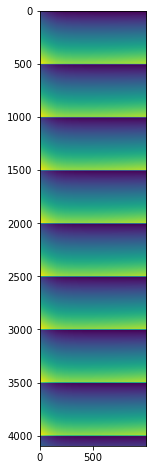

In [50]:
%time result = parallel_read_decompress_integrate(filename, h5path, nbthreads, worker_numpy)
fig,ax = subplots(figsize=(8,8))
ax.imshow(result)

## 7. Evolution of the performances with the number of threads

In [51]:
performances_h5py = {}
performances_file = {}
performances_memmap = {}
for i in (64, 56, 48, 40, 36, 32, 28, 24, 20,16, 12, 8, 4, 2, 1):
    print(f"Using {i} threads")
    
    t = %timeit -r1 -n1 -o parallel_decompress_integrate(filename, h5path, i)
    performances_h5py[i] = nbframes/t.best

    t = %timeit -r1 -n1 -o parallel_read_decompress_integrate(filename, h5path, i, worker_python)
    performances_file[i] = nbframes/t.best

    t = %timeit -r1 -n1 -o parallel_read_decompress_integrate(filename, h5path, i, worker_numpy)
    performances_memmap[i] = nbframes/t.best


Using 64 threads
8.58 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
8.64 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
7.38 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Using 56 threads
8.4 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
8.62 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
7.15 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Using 48 threads
6.54 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
7.93 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
7.49 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Using 40 threads
7.8 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
8.08 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
7.48 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Using 36 threads
7.48 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
8.34 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
8 s ± 0 ns per loop (

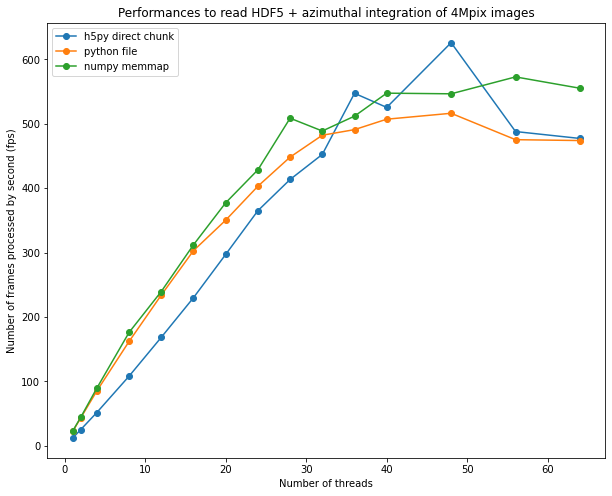

In [56]:
fig, ax = subplots(figsize=(10,8))
ax.plot(list(performances_h5py.keys()),list(performances_h5py.values()), "o-", label="h5py direct chunk")
ax.plot(list(performances_file.keys()),list(performances_file.values()), "o-", label="python file")
ax.plot(list(performances_memmap.keys()),list(performances_memmap.values()), "o-", label="numpy memmap")
ax.legend()
ax.set_xlabel("Number of threads")
ax.set_ylabel("Number of frames processed by second (fps)")
ax.set_title("Performances to read HDF5 + azimuthal integration of 4Mpix images")
pass

## 8. Conclusion

Reading Bitshuffle-LZ4 data can be parallelized using multi-threading in Python. 

The procedure is a bit tedious but not out of reach for a Python programmer: few threads and a couple of queues. 
This burden is worth when coupling decompression with azimuthal integration to reduce the amount of data  stored in memory.

The performances obtained on a 64-core computer are close to what can be obtained from a GPU: ~500 fps
The speed-up obtained with the procedure is 30x on a 64-core computer versus single threaded implementation, which demonstrates multithreading is worth the burden.

One notices the effort for going arount the different locks from `HDF5` and `h5py` did not bring much more performances. This could be linked to a common limiting factor: the `GIL`. 
This demonstration shows multithreaded python is possible but the number of effectively parallel threads is 
limited around 40-48 threds on the 2x32 core computer. 
Other methods exists to have more simulaneous core: multiprocessing, but also GPU processing which exposed in other notebooks.

Thanks again to the French-CRG for the computer.

In [53]:
print(f"Total processing time: {time.time()-start_time:.3f} s")

Total processing time: 1988.758 s
